## Image Operations

Author: Julian Lißner

For questions and feedback write a mail to: [lissner@mib.uni-stuttgart.de](mailto:lissner@mib.uni-stuttgart.de)

In [178]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import sys
from datetime import datetime

sys.path.append( 'submodules' )
import display_functions as plot
import image_padding as padding
import image_kernels as kernels
import image_conversion as convert
import image_processing as process

## Convolution operation

- convolution of an image with a kernel shows the local match of the kernel $k\in \mathbb R^{3\times 3}$ in the image $A \in \mathbb R^{n\times n}$
- the convolution at point $ij$ in the resulting image $C$ is defined as

$$
C(i,j) = \sum\limits_{o=i-1}^{i+1} \sum\limits_{p=j-1}^{j+1} A(i+o, j+p) \cdot k_(-o, -p)
$$
- and can be visualized as
<img src='figures/image_convolution.png'>

- there are multiple ways to correctly implement the convolution
- example for interpretation
- the convolution is not defined for values at the edges $i<m$ <br>

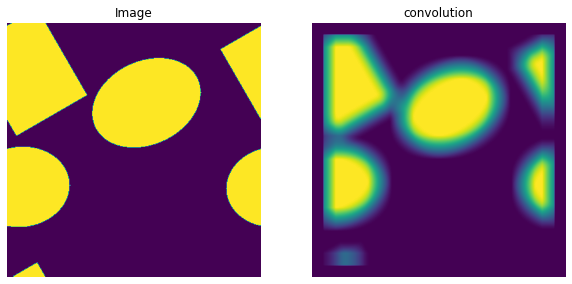

In [179]:
plot.unpadded_convolution()

- padding can circumvent undesired effects
- undefined values can be computed with padding
- different paddings have different results
- popular paddings are: zero, constant, periodic, ones

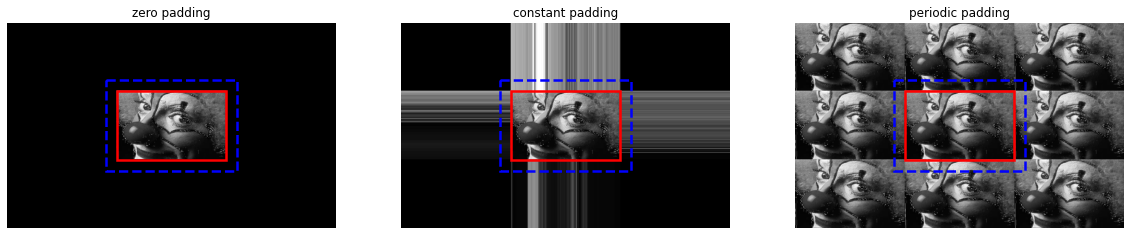

In [181]:
image = convert.load_grayscale( 'figures/clown.jpg')
image = 255-image

pad = 32

fig, axes = plt.subplots( 1,3, figsize=(20,8) )
axes[0].imshow( padding.zero_padding( image, pad_size='full'), cmap='gray' )
axes[1].imshow( padding.constant_padding( image, pad_size='full'), cmap='gray' )
axes[2].imshow( padding.periodic_padding( image, pad_size='full'), cmap='gray' )

padded_box_pos = np.array( image.shape) - pad
padded_box_width = np.array( image.shape) + 2*pad 
titles = ['zero padding', 'constant padding', 'periodic padding' ]
for ax in axes:
    image_highlight = patch.Rectangle( image.shape[::-1], *image.shape[::-1], linewidth=2.5, edgecolor='red', facecolor='none' )
    padded_image = patch.Rectangle( padded_box_pos[::-1], *padded_box_width[::-1], linewidth=2.5, edgecolor='blue', linestyle='--', facecolor='none' )
    ax.add_patch( padded_image)
    ax.add_patch( image_highlight)
    ax.axis( 'off')
    ax.set_title( titles.pop( 0))

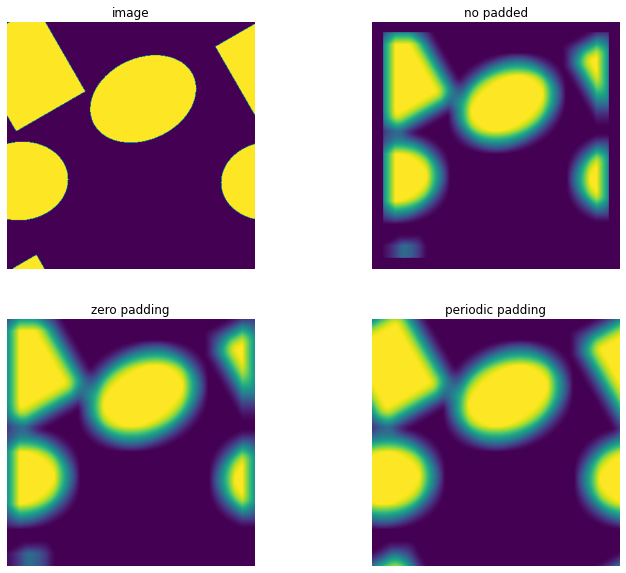

In [193]:
plot.padding_examples()

- convolution can be used to detect the match in the image with the kernel

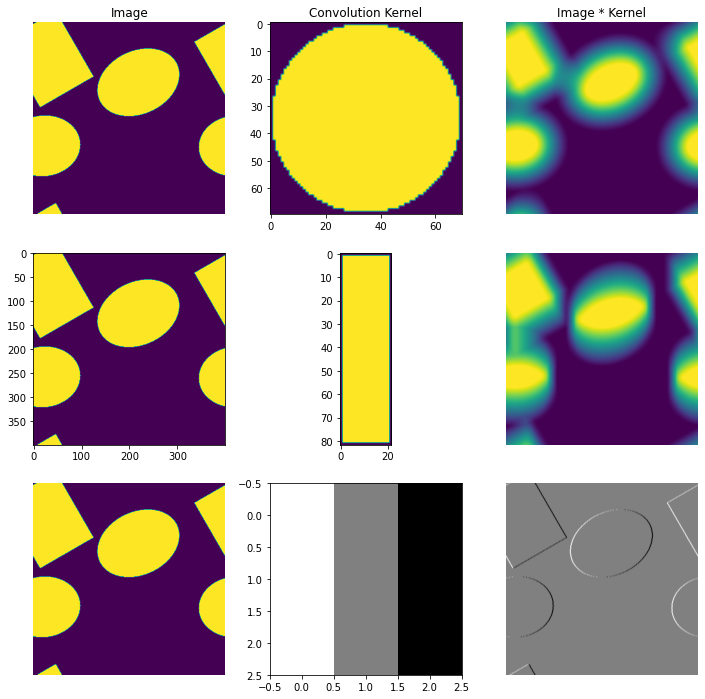

In [183]:
plot.convolution_examples() 

- convolution can be used to apply a kernel as a stencil onto the activations

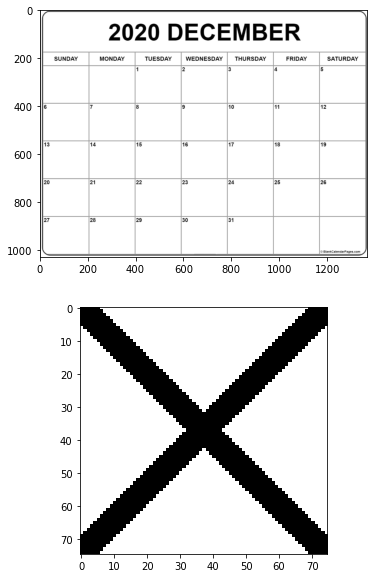

In [184]:
calendar = convert.load_grayscale( 'figures/calendar.png' )


date_offset_v = 320
date_offset_h = 100
date_increment_v = 155
date_increment_h = 195
weekdays = 7
day_offset = 2
datebox_size = 75
cross = -kernels.cross( datebox_size) *255 #set the kernel to be 'negative white'

fig, axes = plt.subplots( 2, 1, figsize=(10,10) )
axes = axes.flatten()
axes[0].imshow( calendar, cmap='gray')
axes[1].imshow( cross, cmap='gray')

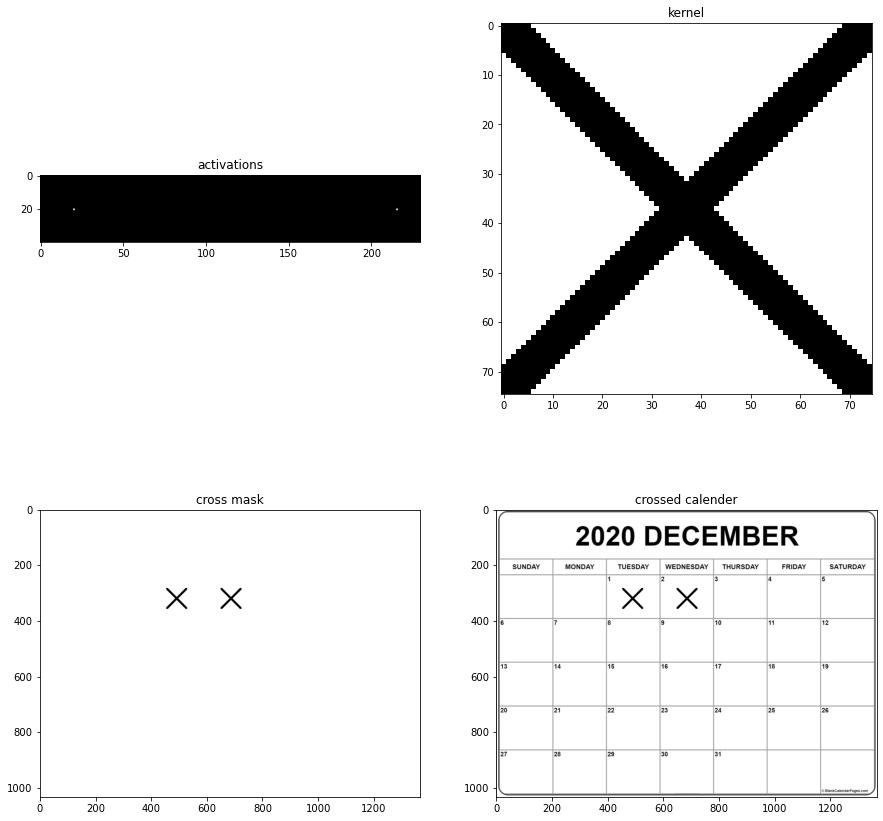

In [185]:
## Get the date of today
today = str( datetime.now() )
month = int( today[ 5:7] )
if month != 12: #if you not in december (only future possible)
    day = 31
else:
    day = int( today[ 8:10] )

day = day #you may hard overwrite the day for testing

## mark points at each passed day
cross_marks = np.zeros( calendar.shape ) 
full_weeks = (day+day_offset) // weekdays
for i in range( full_weeks):
    vertical_pos = date_offset_v + i * date_increment_v
    for j in range( weekdays):
        if i == 0 and j < day_offset:
            continue
        horizontal_pos = date_offset_h + j * date_increment_h
        cross_marks[ vertical_pos, horizontal_pos ] = 1

## if not the full week is crossed, compute how many days to cross
vertical_pos = date_offset_v + full_weeks * date_increment_v
for j in range( (day + day_offset) % weekdays):
    if full_weeks == 0 and j < day_offset:
        continue
    horizontal_pos = date_offset_h + j * date_increment_h
    cross_marks[ vertical_pos, horizontal_pos ] = 1

crosses = process.periodic_convolution( cross_marks, cross )
crossed_calendar = calendar + crosses

fig, axes = plt.subplots( 2, 2, figsize=(15,15))
axes = axes.flatten()
axes[0].imshow( cross_marks[300:340, 470:700], cmap='gray' )
axes[1].imshow( cross, cmap='gray' )
axes[2].imshow( crosses, cmap='gray')
axes[3].imshow( calendar+crosses, cmap='gray')
titles = ['activations', 'kernel', 'cross mask', 'crossed calender']
for ax in axes:
    ax.set_title( titles.pop(0))
plt.show()

-----------------------------
## Erosion and dilation
- dilation places the kernel wherever it is activated
- erosion deletes everything except points where the kernel fuly fits
- erosion and dilation are counterparts, but both invertible
- a dilation does not revert an erosion, this process is called opening
- vice versa dilation then erosion is called closing
- opening and closing are used to remove _salt and pepper_ noise, missing/wrongly placed pixels
- closing 'closes' small gaps in foreground, removing _pepper_ noise
- opening 'opens' the background, removing _salt_ noise

<img src='figures/opening_closing.png'>

-------------
## Denoising and filtering
- low pass filtering smoothes out image
- high pass filtering enhances/detects local information
- using specific kernels, e.g. Sobel operator, edges can be detected
- edges are local changes in the adjacent neighbourhood
- the vertical Sobel operator is defined as follows
$$ H_H = \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix} $$
$\quad \blacktriangleright$ simplified Sobel operator: $H_1 = [ -1\quad 0\quad 1]$
- convolution with $H_1$ similar to finite differences on a grid with stepsize $h$
$$ d_x = \frac{ x_{i+1} - x{i-1} }{2h} $$

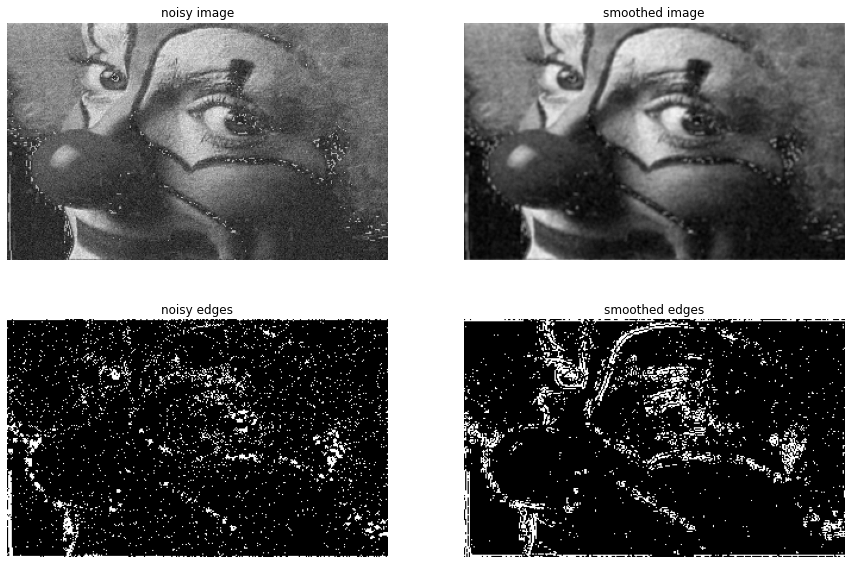

In [192]:
image = 255 - convert.load_grayscale( 'figures/clown.jpg' )
noise = np.random.randn( *image.shape) * 15
image = image + noise
edge_detector = kernels.laplace('full') 
smoothing = kernels.disc( 5, kind='gauss')

smoothed_image = process.periodic_convolution( image, smoothing)

noisy_edges = np.abs( process.periodic_convolution( image, edge_detector ) )
noisy_edges = process.segmentation( noisy_edges, 2.2*noisy_edges.mean())
smoothed_edges = np.abs( process.periodic_convolution( smoothed_image, edge_detector ) )
smoothed_edges = process.segmentation( smoothed_edges, 2.2*smoothed_edges.mean())

fig, axes = plt.subplots( 2, 2, figsize=(15,10))
axes = axes.flatten()
axes[0].imshow( image, cmap='gray')
axes[1].imshow( smoothed_image, cmap='gray')
axes[2].imshow( noisy_edges, cmap='gray')
axes[3].imshow( smoothed_edges, cmap='gray')

titles = ['noisy image', 'smoothed image', 'noisy edges', 'smoothed edges']
for ax in axes:
    ax.set_title( titles.pop(0))
    ax.axis( 'off')

## Processing and old photograph
- application example, restore an old photograph
- multiple steps, opening, sharpening, smoothing, sharpening
- note: grayscale opening is differently implemented than binary opening

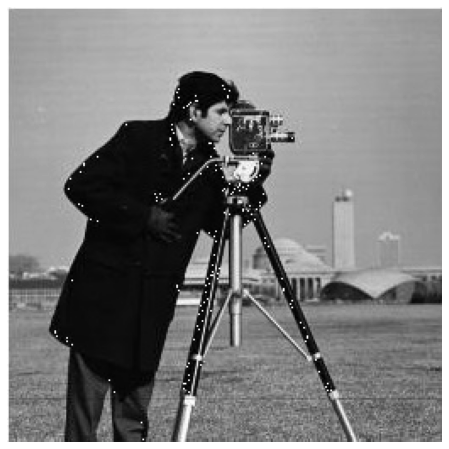

In [187]:
image = convert.load_grayscale( 'figures/photographer_257x257.jpg', 'grayscale' )
image = 255- image #invert iage
original_image = image.copy()

def display( image):
    fig, ax = plt.subplots( figsize=(8,8) )
    ax.imshow( image, cmap='gray' )
    ax.axis('off')
display( image)

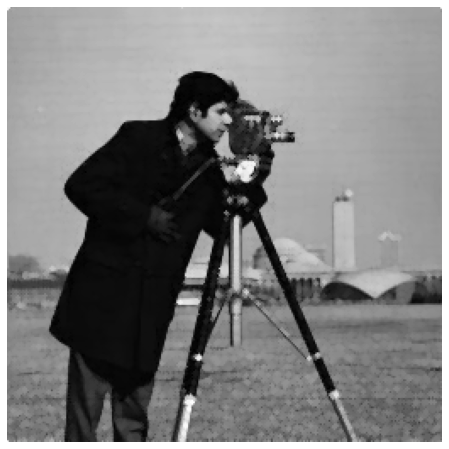

In [188]:
salt_kernel = np.array( [ [ 0, 1, 0],  [ 1, 1,  1], [ 0, 1,  0] ] )
image = process.grayscale_opening( image, salt_kernel)

display( image)

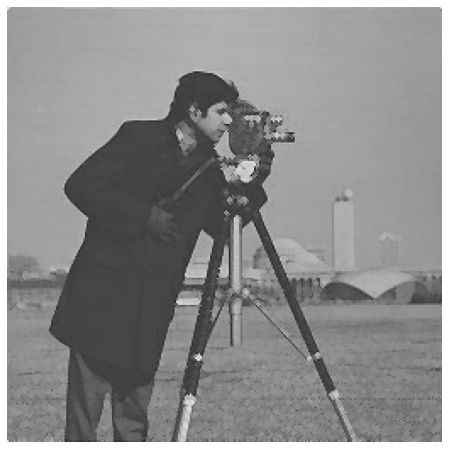

In [189]:
sharpen_kernel = kernels.laplace( 'cross')
sharpening_mask = process.periodic_convolution( image, sharpen_kernel )
image += sharpening_mask 

display( image)

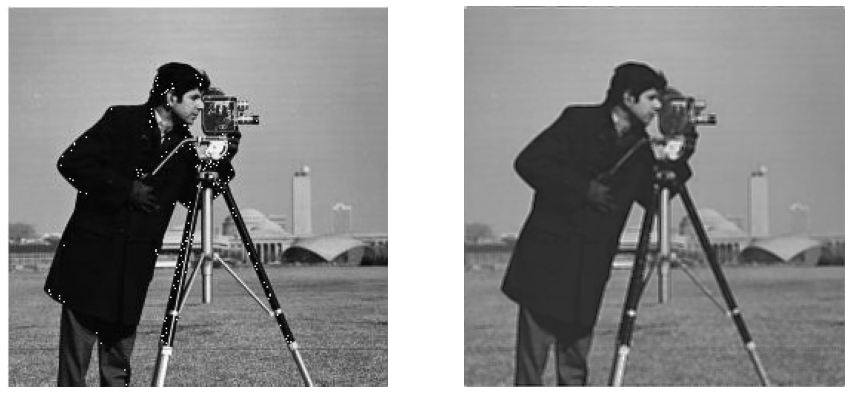

In [190]:
blur_kernel = np.ones( (3,3) )/9
image = process.periodic_convolution( image, blur_kernel)

sharpen_kernel = kernels.laplace( 'full') 
sharpening_mask = process.periodic_convolution( image, sharpen_kernel )
image += sharpening_mask

fig, axes = plt.subplots( 1,2, figsize=(15,12) )
axes[0].imshow( original_image, cmap='gray')
axes[1].imshow( image, cmap='gray')
for ax in axes:
    ax.axis( 'off')

- images can easily be cropped using slicing
- the background is to be omitted and cut out

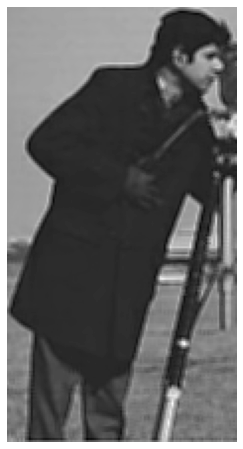

In [191]:
photographer = image[ 37:, 24:140 ]
display( photographer)